This notebook implements different methods to interpret neural network decisions and applies them to Imagenet photos (in 2D) and MRI images from brains with Alzheimer's (the ADNI dataset, in 3D).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

In [2]:
import os

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [4]:
from utils import load_nifti, plot_slices

# General

In [5]:
# Local
data_dir = 'data/adni-sample'

# Remote (Ubuntu)
#data_dir = '/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

# Remote (Mac)
#data_dir = '/Volumes/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

In [38]:
# TODO: What does z_factor do here?
# Load a mask that is applied to all nifti images and strips the skull etc.
#mask = load_nifti('data/WM_GM_mask.nii.gz', z_factor=0.75)
mask = load_nifti('/Volumes/analysis/share/Ritter/Templates/mni_icbm152_nlin_asym_09c/binary_brain_mask.nii.gz')
plot_slices(mask)
mask.shape

(193, 229, 193)

In [7]:
e = 1e-6  # small perturbation to prevent zero division

# Apply methods to Imagenet photos (2D)

In [450]:
model = models.alexnet(pretrained=True)
#model = models.inception_v3(pretrained=True)  # raises an error when predicting
#model = models.vgg19_bn(pretrained=True)

In [458]:
list(list(model.children())[0].children())

[Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1)),
 Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1)),
 Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))]

In [4]:
valdir = 'data/images'

image_means = np.array([0.485, 0.456, 0.406])
image_stds = np.array([0.229, 0.224, 0.225])

normalize = transforms.Normalize(mean=image_means, std=image_stds)

val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=64, shuffle=False,
        num_workers=1, pin_memory=True)

In [5]:
def image_tensor_to_rgb(image_tensor):
    '''Convert a normalized image tensor to an RGB array (that can be displayed via pyplot.imshow).'''
    image = image_tensor.numpy() * image_stds.reshape(3, 1, 1) + image_means.reshape(3, 1, 1)
    image = image.transpose(1, 2, 0)
    return image

def get_image(index):
    image_tensor = val_loader.dataset[index][0]
    return image_tensor_to_rgb(image_tensor), image_tensor

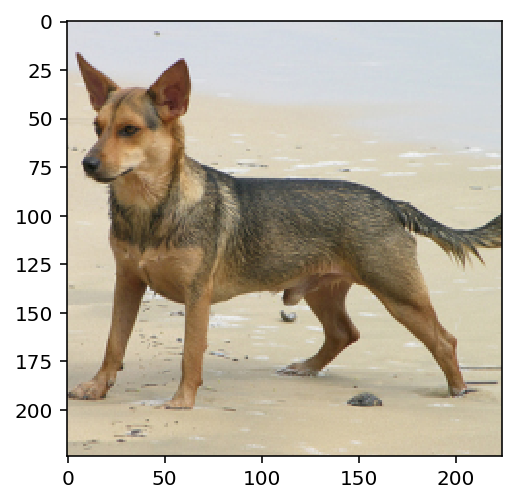

In [6]:
plt.imshow(get_image(0)[0])

In [7]:
# To get the same results as in pytorch-cnn-visualizations (https://github.com/utkuozbulak/pytorch-cnn-visualizations),
# set a fixed target class and do `postprocess=None`.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs'):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    
    model.eval()
    output = model(X)
    output_class = output.max(1)[1].data.numpy()[0]
    print('Image was classified as:', output_class)
    
    model.zero_grad()
    one_hot_output = torch.zeros(output.size())
    if target is None:
        one_hot_output[0, output_class] = 1
    else:
        one_hot_output[0, target] = 1
    output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
    else:
        raise ValueError()
    
def taylor_decomposition(model, image_tensor, target=None):
    relevance_map = sensitivity_analysis(model, image_tensor, target=target)
    
    try:
        image_tensor = image_tensor.numpy()  # if it's a pytorch tensor
    except AttributeError:
        image_tensor = np.asarray(image_tensor)  # if it's a list or anything else
    
    return relevance_map * image_tensor.max(axis=0)  # TODO: How to deal with the several color channels of the image?

In [8]:
def guided_backprop(model, image_tensor, target=None, postprocess='abs'):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        for pos, module in model.features._modules.items():
            if isinstance(module, nn.ReLU):
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [9]:
from pytorch_cnn_visualizations.vanilla_backprop import VanillaBackprop
from pytorch_cnn_visualizations.guided_backprop import GuidedBackprop
from pytorch_cnn_visualizations.misc_functions import convert_to_grayscale

Image was classified as: 232
Image was classified as: 232
Image was classified as: 232
Image was classified as: 249
Image was classified as: 249
Image was classified as: 249
Image was classified as: 947
Image was classified as: 947
Image was classified as: 947
Image was classified as: 27
Image was classified as: 27
Image was classified as: 27


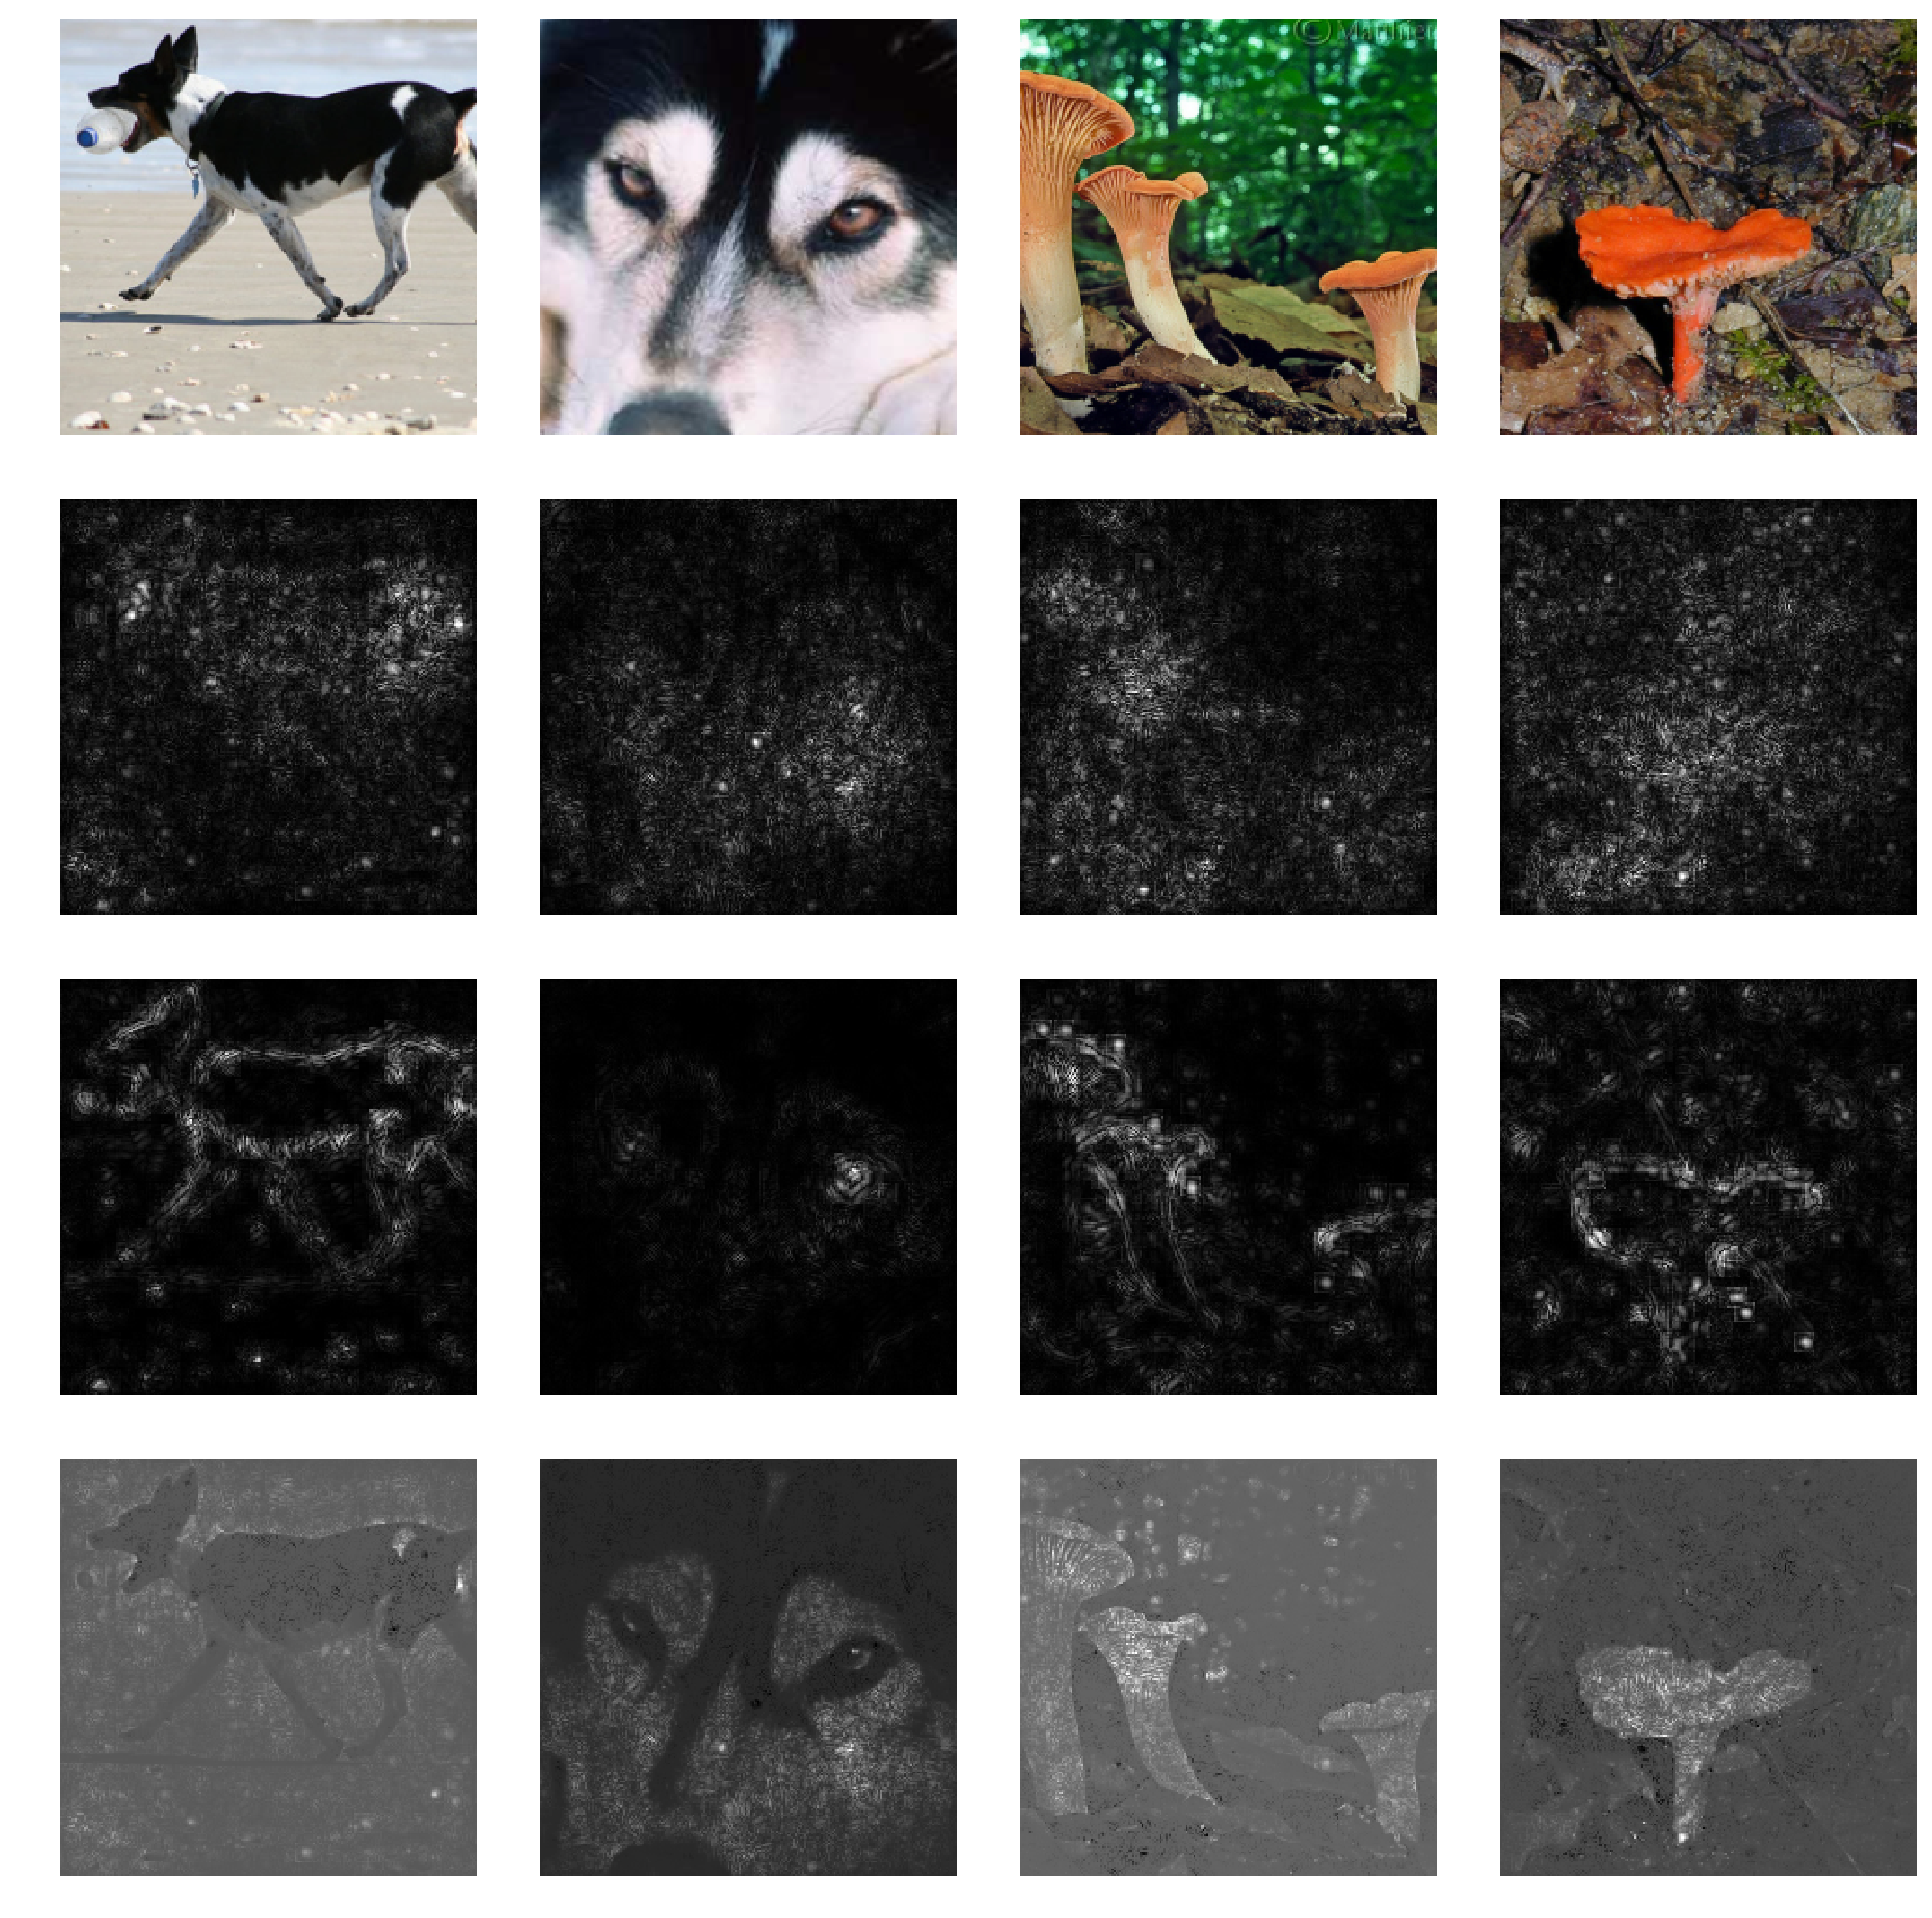

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

offset = 2

for i, vertical_axes in enumerate(axes.T):
    image, image_tensor = get_image(i+offset)
    
    plt.sca(vertical_axes[0])
    plt.axis('off')
    plt.imshow(image)
    
    plt.sca(vertical_axes[1])
    plt.axis('off')
    plt.imshow(sensitivity_analysis(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    #plt.sca(vertical_axes[2])
    #plt.axis('off')
    #vbp = VanillaBackprop(model, Variable(image_tensor[None], requires_grad=True), 227)
    #vbp_heatmap = vbp.generate_gradients()
    #plt.imshow(vbp_heatmap.max(0), cmap='Greys_r')
    
    plt.sca(vertical_axes[2])
    plt.axis('off')
    # TODO: Investigate why my methods are different from the package.
    # Possible reasons: target class, true one-hot vector, abs postprocessing, gradient w.r.t parameters vs input
    plt.imshow(guided_backprop(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    #plt.sca(vertical_axes[4])
    #plt.axis('off')
    # TODO: Target class.
    #gbp = GuidedBackprop(model, Variable(image_tensor[None], requires_grad=True), 227)
    #gbp_heatmap = gbp.generate_gradients()
    #plt.imshow(gbp_heatmap.max(0), cmap='Greys_r')
    #gbp.unhook()
    
    plt.sca(vertical_axes[3])
    plt.axis('off')
    plt.imshow(taylor_decomposition(model, image_tensor).max(0), cmap='Greys_r')

plt.tight_layout()

- 1st row: Image
- 2nd row: Vanilla Backprop (mine)
- 3th row: Guided Backprop (mine)
- 4th row: Taylor Decomposition (mine)

# Apply methods to ADNI data (3D)

In [322]:
# TODO: These are adapted from above in order to deal with binary output instead of softmax. Generalize this.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    if output_mode not in [None, 'binary', 'categorical']:
        raise ValueError("output_mode must be None, 'binary' or 'categorical'")
    if postprocess not in [None, 'abs', 'square']:
        raise ValueError("postprocess must be None, 'abs' or 'sqaure'")
    
    # Forward pass.
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    model.eval()
    output = model(X)
    
    # Backward pass.
    model.zero_grad()
    if output_mode is None:
        output_mode = 'binary' if output.size(1) == 1 else 'categorical'
    if output_mode == 'binary':  # binary output
        # TODO: Does it make sense to always use one here as the output gradient? 
        #       (This is similar to using one-hot below.)
        print('Image was classified as:', output.data.numpy()[0, 0].round())
        output.backward(gradient=torch.ones(output.size()))
    elif output_mode == 'categorical':  # categorical output
        output_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', output_class)
        # TODO: Check if setting to one hot makes sense here.
        one_hot_output = torch.zeros(output.size())
        if target is None:
            one_hot_output[0, output_class] = 1
        else:
            one_hot_output[0, target] = 1
        output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    # Postprocess the relevance map.
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
        
        
def guided_backprop(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ELU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        #for pos, module in model.features._modules.items():
        for module in model.children():
            if isinstance(module, nn.ELU):
                print('Registered hook for layer:', module)
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess, output_mode=output_mode)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        print('Removing {} hook(s)'.format(len(hook_handles)))
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [462]:
net = torch.load('data/models/model_121217_1_converted_to_pytorch.p')

In [463]:
net

ClassificationModel3D(
  (Conv_1): Conv3d (1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_2): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_3): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (dense_1): Linear(in_features=128, out_features=1)
  (elu): ELU(alpha=1.0)
)

In [464]:
# TODO: This is a dirty workaround and only calculates the std across 10 images. Implement a nice way to get the std and mean across all samples.
# TODO: Do not actually calculate these values here, but preserve them somewhere.
all_struct_arr = np.zeros((10, 91, 109, 91))
for i, filename in enumerate(os.listdir(data_dir)[:10]):
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    all_struct_arr[i] = struct_arr
    
pixel_std = all_struct_arr.std(0)

In [465]:
struct_arr = load_nifti('data/adni-sample/AD_0003_wT1.nii', mask=mask)
struct_arr = struct_arr / (pixel_std + e)
struct_arr = struct_arr[None]  # add (empty) channel dimension
struct_arr = torch.from_numpy(struct_arr).float()

X = struct_arr

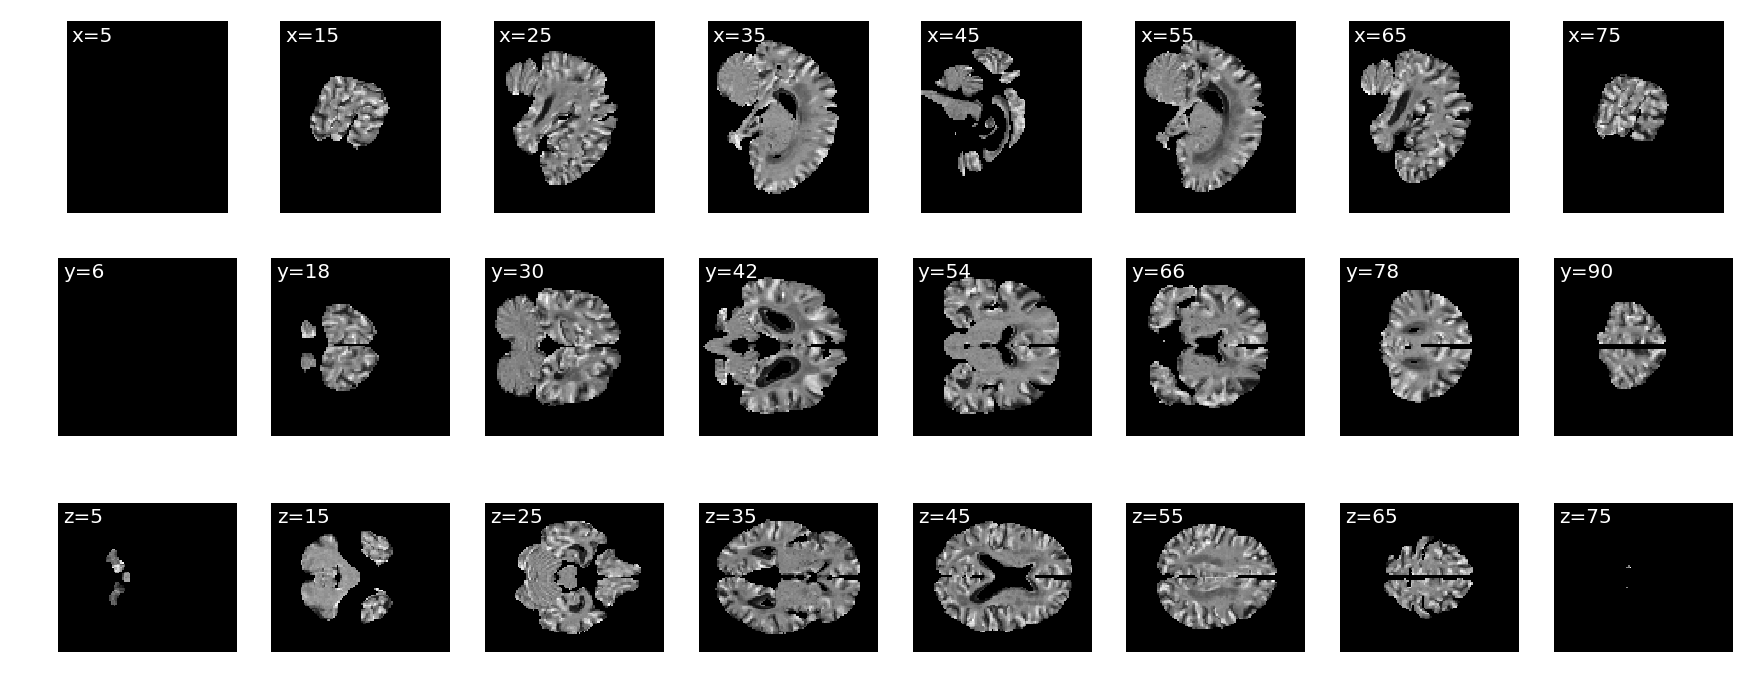

In [466]:
plot_slices(X[0])

In [467]:
relevance_map = sensitivity_analysis(net, X)
relevance_map.shape

Image was classified as: 1.0


(1, 91, 109, 91)

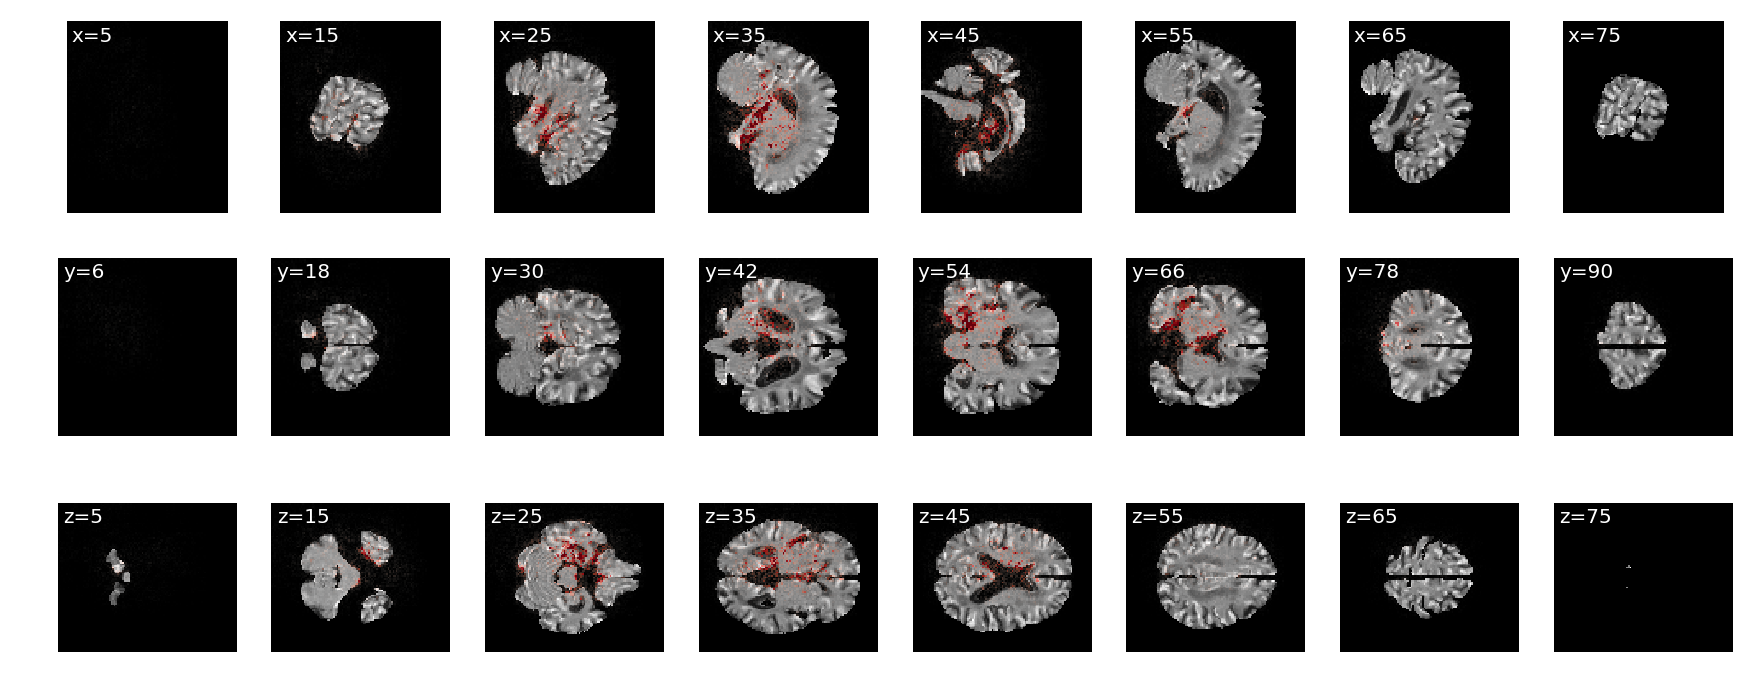

In [468]:
plot_slices(X[0], overlay=relevance_map[0], overlay_vmax=np.percentile(relevance_map, 99.9))

In [469]:
relevance_map_guided = guided_backprop(net, X)
relevance_map_guided.shape

Registered hook for layer: ELU(alpha=1.0)
Image was classified as: 1.0
Removing 1 hook(s)


(1, 91, 109, 91)

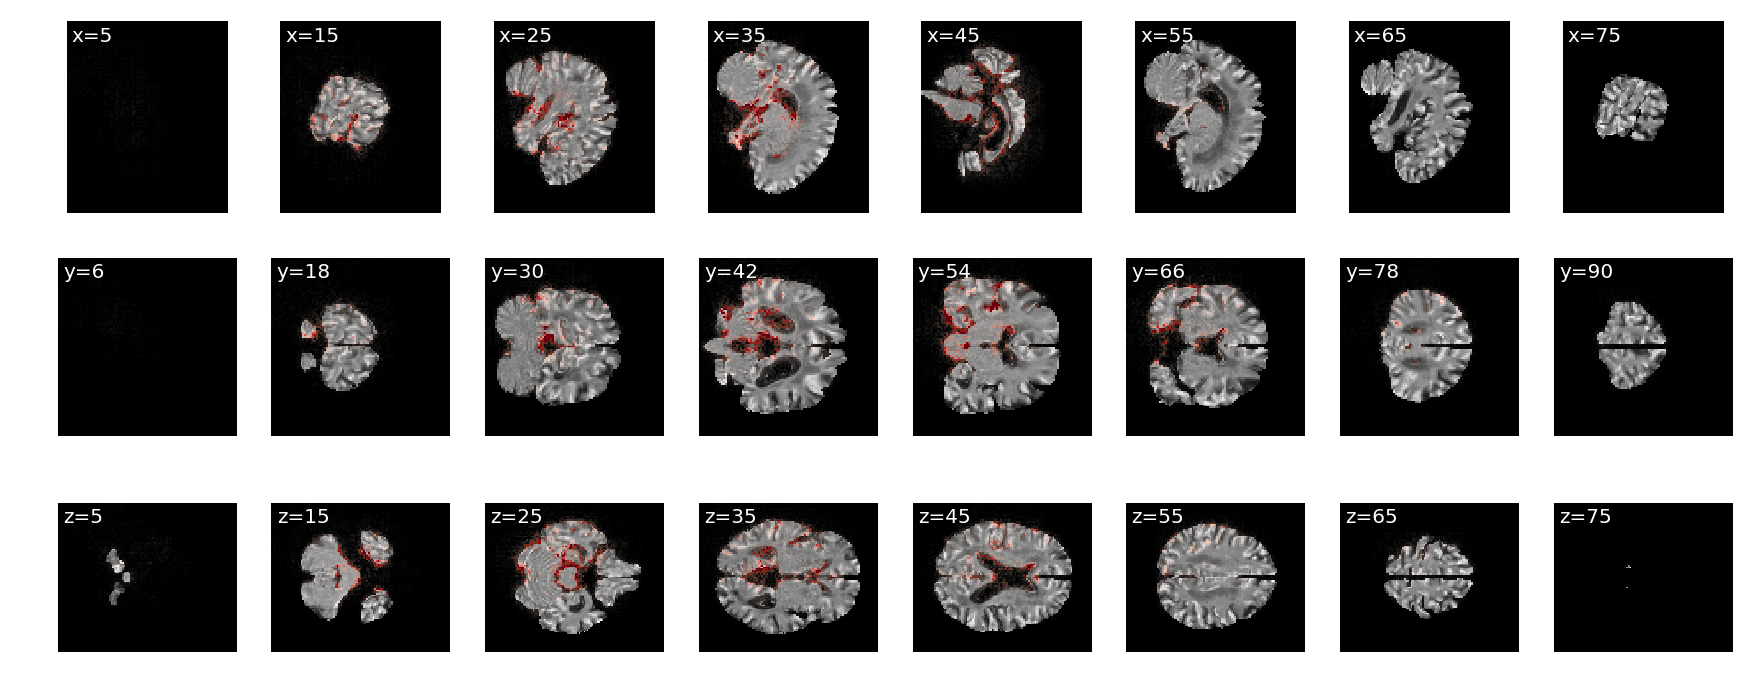

In [470]:
# TODO: Results are equal to normal backprop (they were different/better before the refactoring!).
plot_slices(X[0], overlay=relevance_map_guided[0], overlay_vmax=np.percentile(relevance_map_guided, 99.9))

In [472]:
np.mean(relevance_map == relevance_map_guided)

0.50940751958999764

# Read ADNI data from file system

In [ ]:
# Read our ADNI table and get corresponding images.

In [8]:
# Local
#adni_root_dir = 'data/adni-sample'

# Remote (Ubuntu)
#adni_root_dir = '/analysis/share/ADNI'

# Remote (Mac)
#adni_root_dir = '/Volumes/analysis/share/ADNI'

In [12]:
images_root_dir = '/Volumes/analysis/share/ADNI/ADNI_2Yr_3T_preprocessed'
table_path = '/Volumes/analysis/share/ADNI/ADNI_tables/customized/DxByImgClean_CompleteAnnual2YearVisitList_3T.csv'

In [13]:
df = pd.read_csv(table_path)
df.head()

RID        PTID VISCODE   DX    EXAMDATE  Image.ID Scan.Date  \
0   15  100_S_0015      bl   CN  2005-10-18     33046  10/31/05   
1   15  100_S_0015     m12   CN  2006-10-13     63475  10/16/06   
2   15  100_S_0015     m24   CN  2007-10-11     82551  10/11/07   
3   30  023_S_0030      bl  MCI  2005-10-20     31623  10/26/05   
4   30  023_S_0030      bl  MCI  2005-10-20    118790  10/26/05   

                                     Sequence     Visit  Month_bl  \
0                         MPR-R; ; N3; Scaled  Baseline    0.0000   
1                         MPR-R; ; N3; Scaled  Month 12   11.8033   
2                           MPR; ; N3; Scaled  Month 24   23.7049   
3    MPR; GradWarp; B1 Correction; N3; Scaled  Baseline    0.0000   
4  MPR; GradWarp; B1 Correction; N3; Scaled_2  Baseline    0.0000   

  Screen.Diagnosis  Study.ID  Series.ID  
0               NL      2613       8833  
1               NL      5490      20311  
2               NL     13281      41463  
3              MCI      2591       8908  
4              MCI      2591       8908

Important columns in the table:

- PTID: Patient ID
- VISCODE: Visit code (bl=baseline, mx=after x months) (see also Visit)
- DX: Diagnosis (CN=control, MCI=mild cognitive impairment, Dementia=Alzheimer's disease)
- Image.ID: Image ID

The filenames of the corresponding images are: `<PTID>_<Scan.Date with - instead of />_<Visit>_<Image.ID>_<DX>.nii`

In [46]:
df['DX'].value_counts()

MCI         98
CN          93
Dementia    88
Name: DX, dtype: int64

In [387]:
# TODO: Check what DX and Screen.Diagnosis say (according to Nikolai: Screen.Diagnosis is diagnois before the image was taken, i.e. DX should always be worse than Screen.Diagnosis).

In [87]:
def get_image_filepath(df_row, root_dir=''):
    """Return the filepath to the image that belongs to a row in the dataframe."""
    filename = 'INTERNAL_WARPED.nii.gz'#"{}_{}_{}_{}_{}.nii".format(df_row['PTID'], df_row['Scan.Date'].replace('/', '-'), df_row['Visit'], df_row['Image.ID'], df_row['DX'])
    filepath = os.path.join(root_dir, df_row['PTID'], df_row['Visit'].replace(' ', ''), filename)
    return filepath

get_image_filepath(df.loc[0])

u'100_S_0015/Baseline/INTERNAL_WARPED.nii.gz'

In [88]:
# These are the images where preprocessing failed.
corrupt_images = ['037_S_0501/Baseline', '037_S_0501/Month12', '037_S_0501/Month24', '051_S_1123/Baseline', '051_S_1123/Month12', '051_S_1123/Month24', '116_S_0649/Month12', '116_S_0649/Month24', '116_S_1232/Baseline', '027_S_1387/Baseline', '027_S_1387/Month12', '027_S_1387/Month24', '116_S_0382/Baseline', '027_S_0404/Baseline', '027_S_0404/Month24', '027_S_1385/Month12', '023_S_0376/Month12', '023_S_0030/Baseline', '023_S_0030/Month24', '023_S_1247/Baseline', '023_S_1247/Month12', '027_S_1082/Month24', '018_S_0450/Baseline', '005_S_0572/Baseline', '005_S_0572/Month12', '005_S_0572/Month24']

In [90]:
# Get all images for each diagnosis.
import collections

image_filepaths = collections.defaultdict(list)#{}

# TODO: Filter out images where preprocessing failed.
for diagnosis in ['CN', 'MCI', 'Dementia']:
    for _, row in df[df['DX'] == diagnosis].iterrows():
        image_filepath = get_image_filepath(row, root_dir=images_root_dir)
        if os.path.exists(image_filepath):
            image_filepaths[diagnosis].append(image_filepath)
        else:
            print('File does not exist:', image_filepath)
        
     #   image_filepaths[diagnosis].append(image_filepath)
    print('{}: Added {} files'.format(diagnosis, len(image_filepaths[diagnosis])))
    #image_filepaths[diagnosis] = list(df[df['DX'] == diagnosis].apply(get_image_filepath, axis=1, root_dir=images_root_dir))

CN: Added 93 files
File does not exist: /Volumes/analysis/share/ADNI/ADNI_2Yr_3T_preprocessed/037_S_0501/Month12/INTERNAL_WARPED.nii.gz
MCI: Added 97 files
File does not exist: /Volumes/analysis/share/ADNI/ADNI_2Yr_3T_preprocessed/027_S_1387/Month24/INTERNAL_WARPED.nii.gz
Dementia: Added 87 files


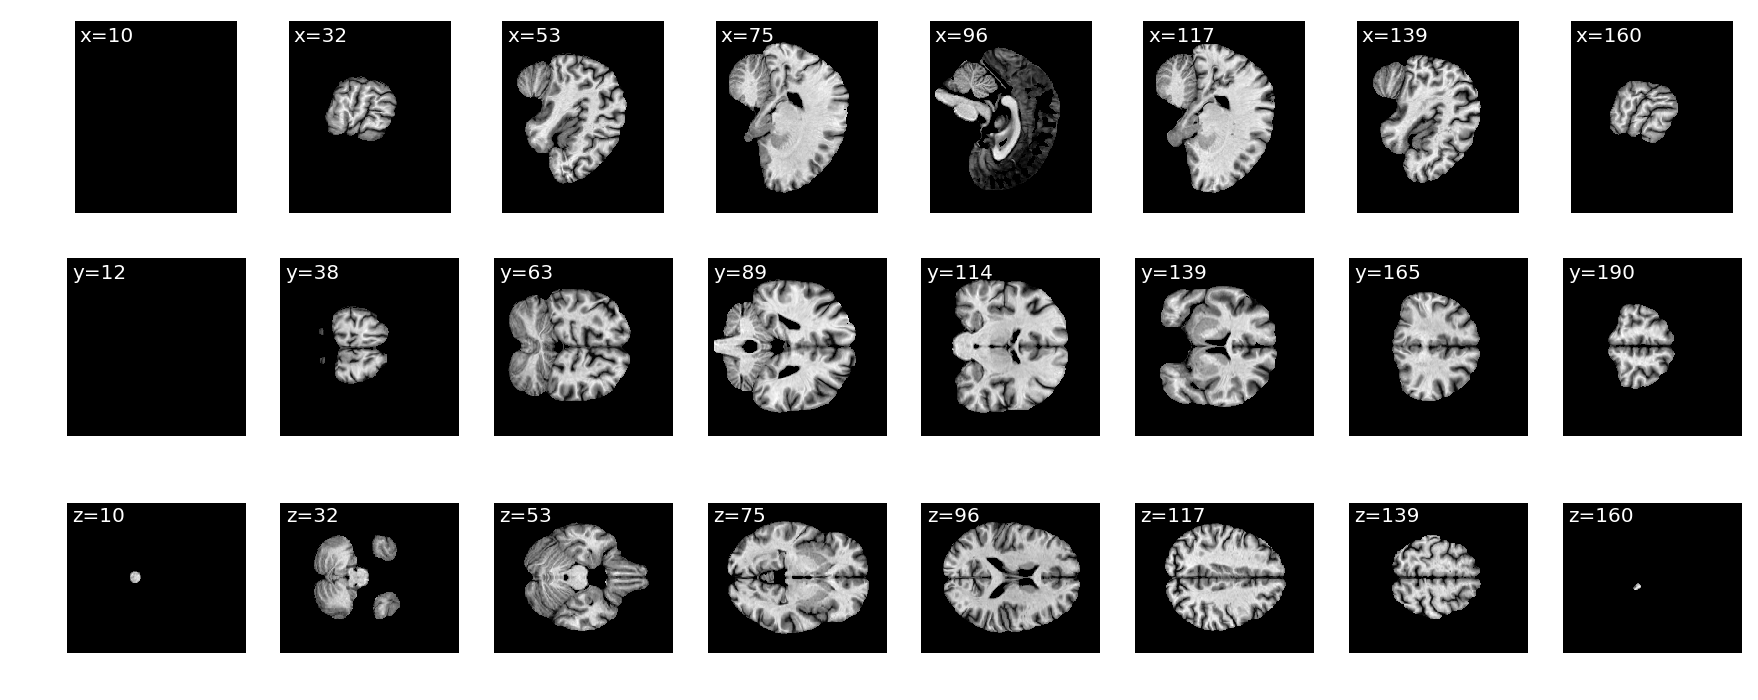

In [79]:
plot_slices(load_nifti(image_filepaths['CN'][0], mask=mask))

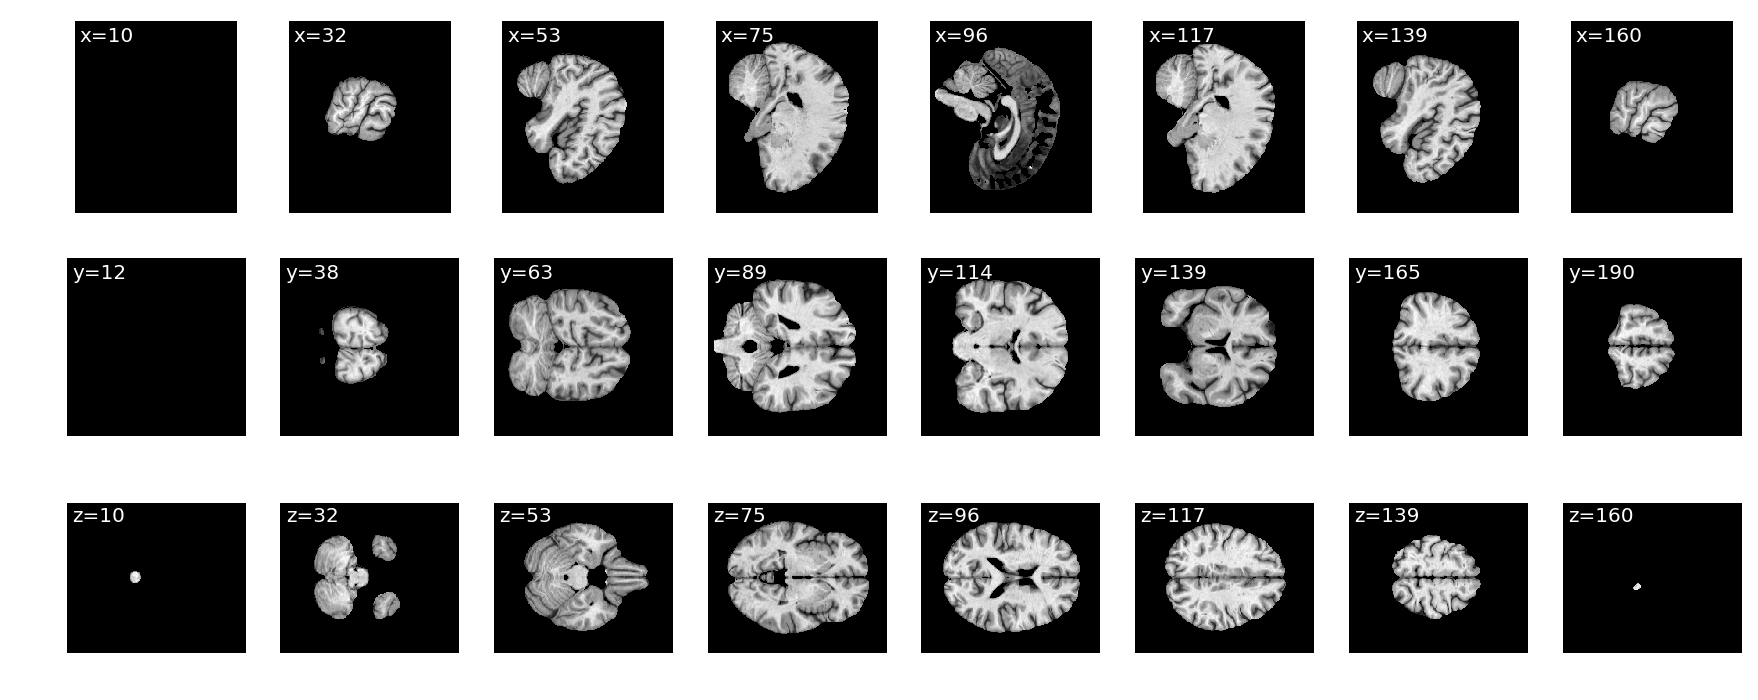

In [80]:
plot_slices(load_nifti(image_filepaths['MCI'][5], mask=mask))

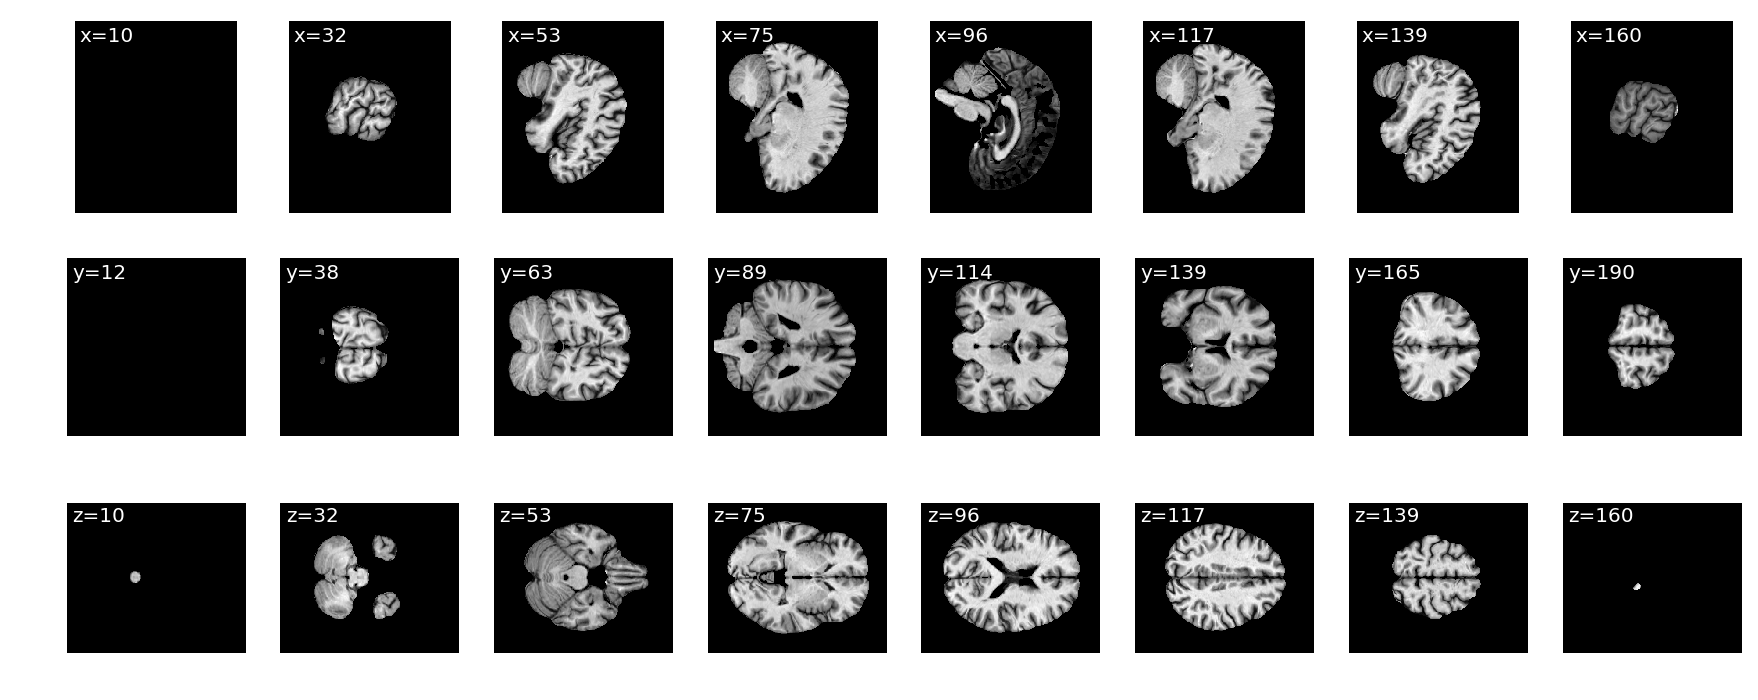

In [81]:
plot_slices(load_nifti(image_filepaths['Dementia'][2], mask=mask))

In [418]:
mprage_ranking_table_filename = '/Users/D068730/Downloads/MRIMPRANK (1).csv'

In [422]:
df_ranking = pd.read_csv(mprage_ranking_table_filename)
df_ranking

Phase     ID   RID  SITEID VISCODE    USERDATE USERDATE2  RECNO  \
0     ADNI1      8     2     107      sc  2006-11-13       NaN      1   
1     ADNI1     10     2     107      sc  2006-11-13       NaN      2   
2     ADNI1     12     2     107     m06  2006-11-13       NaN      3   
3     ADNI1     14     2     107     m06  2006-11-13       NaN      4   
4     ADNI1     16     3     107      sc  2006-11-13       NaN      1   
5     ADNI1     18     3     107      sc  2006-11-13       NaN      2   
6     ADNI1     20     3     107     m06  2006-11-13       NaN      3   
7     ADNI1     22     3     107     m06  2006-11-13       NaN      4   
8     ADNI1     24     3     107     m12  2006-11-13       NaN      5   
9     ADNI1     26     3     107     m12  2006-11-13       NaN      6   
10    ADNI1     28     5     107      sc  2006-11-13       NaN      1   
11    ADNI1     30     5     107      sc  2006-11-13       NaN      2   
12    ADNI1     32     5     107     m06  2006-11-13       NaN      3   
13    ADNI1     34     5     107     m06  2006-11-13       NaN      4   
14    ADNI1     36     5     107     m12  2006-11-13       NaN      5   
15    ADNI1     38     5     107     m12  2006-11-13       NaN      6   
16    ADNI1     40     7      10      sc  2006-11-13       NaN      1   
17    ADNI1     42     7      10      sc  2006-11-13       NaN      2   
18    ADNI1     44     7      10     m06  2006-11-13       NaN      3   
19    ADNI1     46     7      10     m06  2006-11-13       NaN      4   
20    ADNI1     48    15       4      sc  2007-02-01       NaN      1   
21    ADNI1     50    15       4      sc  2007-02-01       NaN      2   
22    ADNI1     52    15       4     m06  2007-02-01       NaN      3   
23    ADNI1     54    15       4     m06  2007-02-01       NaN      4   
24    ADNI1     56    15       4     m06  2007-02-01       NaN      5   
25    ADNI1     58    15       4     m06  2007-02-01       NaN      6   
26    ADNI1     60    15       4     m12  2007-02-01       NaN      7   
27    ADNI1     62    15       4     m12  2007-02-01       NaN      8   
28    ADNI1     64    15       4     m12  2007-02-01       NaN      9   
29    ADNI1     66    15       4     m12  2007-02-01       NaN     10   
...     ...    ...   ...     ...     ...         ...       ...    ...   
9382  ADNI1  19076   241     107     m18  2010-11-01       NaN     13   
9383  ADNI1  19078   241     107     m18  2010-11-01       NaN     14   
9384  ADNI1  19080   362     107     m18  2010-11-01       NaN     15   
9385  ADNI1  19082   362     107     m18  2010-11-01       NaN     16   
9386  ADNI1  19084  1421      18     m36  2010-11-01       NaN      9   
9387  ADNI1  19086  1421      18     m36  2010-11-01       NaN     10   
9388  ADNI1  19088    89      36      nv  2010-11-01       NaN     11   
9389  ADNI1  19090    89      36      nv  2010-11-01       NaN     12   
9390  ADNI1  19092   887      11      nv  2010-11-01       NaN     11   
9391  ADNI1  19094   887      11      nv  2010-11-01       NaN     12   
9392  ADNI1  19096   830      15      nv  2010-11-01       NaN     29   
9393  ADNI1  19098   830      15      nv  2010-11-01       NaN     30   
9394  ADNI1  19100   657       5      nv  2010-11-01       NaN     11   
9395  ADNI1  19102   657       5      nv  2010-11-01       NaN     12   
9396  ADNI1  19104   813      17      nv  2010-11-01       NaN      9   
9397  ADNI1  19106   813      17      nv  2010-11-01       NaN     10   
9398  ADNI1  19108   625      11      nv  2010-11-01       NaN     28   
9399  ADNI1  19110   625      11      nv  2010-11-01       NaN     29   
9400  ADNI1  19112   906      52      nv  2010-11-01       NaN     11   
9401  ADNI1  19114   906      52      nv  2010-11-01       NaN     12   
9402  ADNI1  19116   920      52      nv  2010-11-01       NaN     21   
9403  ADNI1  19118   920      52      nv  2010-11-01       NaN     22   
9404  ADNI1  19120   923      52      nv  2010-11-01       NaN  

# Traverse pytorch model
This is some preliminary exploration, but might be needed to implement LRP.

In [137]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    #dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                print('Tensor:', str(id(var)), size_to_str(var.size()))
                #dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
                pass
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                print('Variable: ', str(id(var)), node_name)
                #dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                print('Whatever: ', str(id(var)), str(type(var).__name__))
                #dot.node(str(id(var)), str(type(var).__name__))
                pass
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        #dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    #dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    #return dot

In [138]:
make_dot(out)

Whatever:  4548426488 SigmoidBackward
Whatever:  4548426240 AddmmBackward
Variable:  4557421072 
 (1)
Whatever:  4548425744 ViewBackward
Whatever:  4548425496 MaxPool3dBackward
Whatever:  4548425248 ELUBackward
Whatever:  4551987600 ConvNdBackward
Whatever:  4548425000 ELUBackward
Whatever:  4551987344 ConvNdBackward
Whatever:  4548424752 MaxPool3dBackward
Whatever:  4548424504 ELUBackward
Whatever:  4551990608 ConvNdBackward
Whatever:  4548424256 MaxPool3dBackward
Whatever:  4548424008 ELUBackward
Whatever:  4551987984 ConvNdBackward
Variable:  4551989392 
 (64, 1, 3, 3, 3)
Variable:  4551988944 
 (64)
Tensor: 4955330608 (1, 64, 89, 107, 89)
Tensor: 4559218664 (1, 64, 89, 107, 89)
Tensor: 4574505080 (1, 64, 89, 107, 89)
Tensor: 4574505512 (1, 64, 29, 35, 29)
Variable:  4551988496 
 (64, 64, 3, 3, 3)
Variable:  4551990928 
 (64)
Tensor: 4574504000 (1, 64, 27, 33, 27)
Tensor: 4574506016 (1, 64, 27, 33, 27)
Tensor: 4574503352 (1, 64, 27, 33, 27)
Tensor: 4574506304 (1, 64, 9, 11, 9)
Varia

In [158]:
def traverse(node, indent='  '):
    #if torch.is_tensor(node): print('tensor')
    if not hasattr(node, 'variable'):
        
        print(indent, node)
        if node is not None:
            for next_node_tuple in node.next_functions:
                traverse(next_node_tuple[0], indent+'  ')
        
        
traverse(out.grad_fn)

                               None


In [144]:
out.grad_fn.next_functions[0][0].grad_fn

AttributeError: 'AddmmBackward' object has no attribute 'grad_fn'